# Exercise 5: Replica exchanage umbrella sampling

In the exercise, our goal is to use replica exchanage umbrella sampling for the NaCl system in the NVT ensemble and compute a free energy profile consistent with the ones we obtained in Exercise 2 (Umbrella sampling) and Exercise 3 (Multiple walkers metadynamics). We will stick with the choice of the ion-pair distance as the collective variable of interest and the REUS simulation will be performed with 8 replicas in parallel on Bridges-2.

For each of the 8 replicas, we will do the following:
- **Step 1**: Create a folder with the filename in the form of `rep_*`.
- **Step 2**: Prepare an `mdp` file for each folder/replica. 
- **Step 3**: Prepare a `gro` file for each folder/replica. It is recommended to initialize each replica with a different configuration.
- **Step 4**: Generate an `tpr` file for each folder/replica and run REUS. 

In [1]:
%%bash
# Here we remove the output of the exercise if there is any.
dirs=(rep_*)
for dir in "${dirs[@]}"; do
    if ls -d "$dir" >/dev/null 2>&1; then
        rm -rf "$dir"
    fi
done

In [2]:
%%bash
cp ../Exercise_2/NaCl_umbrella.mdp NaCl_REUS.mdp
# sed -i -e "s/nsteps = 250000/nsteps = 2500000/g" NaCl_REUS.mdp
# sed -i -e "s/pull-coord1-k = 8000/pull-coord1-k = 20000/g" NaCl_REUS.mdp
# echo 'pull-coord1-kB = 8000  ; kJ mol^-1 nm^-2

echo '
; Free energy calculation
free_energy              = yes
calc-lambda-neighbors    = -1
sc-alpha                 = 0.5
sc-power                 = 1 
couple-moltype           = NA
couple-lambda0           = vdw-q
couple-lambda1           = none
couple-intramol          = yes
init-lambda-state        = 0

nstdhdl                  = 100
dhdl-print-energy        = total

; lambda-states          = 1      2      3      4      5      6      7      8
restraint-lambdas        = 0      0.2    0.3    0.5    0.7    0.8    0.9      1.00
; restraint-lambdas        = 1      1      1.     1.     1.     1.     1      1.00
' >> NaCl_REUS.mdp
# tail -n +2 NaCl_REUS.mdp | sponge NaCl_REUS.mdp  # delete the first line "define-DPOSRES_NA"

In [3]:
%%bash
cat NaCl_REUS.mdp

define=-DPOSRES_NA
integrator = md 
dt = 0.002
nsteps = 250000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
compressibility = 4.5e-5
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000

; Pull code
pull = yes
pull-ncoords = 1                  ; Here we only have 1 CV.
pull-ngroups = 2                  ; We have 2 groups (one immobile/reference group and one pull group).
pull-group1-name = NA             ; index 1
pull-group2-name = CL             ; index 2
pull-coord1-groups = 1 2          ; groups with indices 1 (NA) and 2 (CL) are involved
pull-coord1-type = umbrella       ; harmonic potential
pull-coord1-geometry = distance   ; simple distance increase
pull-coord1-dim = Y Y Y           ; We allow pulling from any directions.
pull-coord1-start = yes           ; We start the pulling with the initial ion-pair distance.
pull

In [4]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

for i in {0..7}
do
    mkdir rep_${i} && cd rep_${i}
    cp ../../Exercise_2/sim_${i}/NaCl_${i}.gro .    # configurations from the US pulling simulation
    # cp ../../Inputs/NaCl/NaCl.top .
    cp ../../Exercise_2/pull/NaCl_US.top NaCl.top
    cp ../../Exercise_2/pull/Na_posres.itp .
    cp ../NaCl_REUS.mdp .
    sed -i -e "s/init-lambda-state        = 0/init-lambda-state        = ${i}/g" NaCl_REUS.mdp
    mpirun -np 1 gmx_mpi grompp -f NaCl_REUS.mdp -r NaCl_${i}.gro -c NaCl_${i}.gro -p NaCl.top -o NaCl_REUS.tpr
    # mpirun -np 1 gmx_mpi grompp -f NaCl_REUS.mdp -c NaCl_${i}.gro -p NaCl.top -o NaCl_REUS.tpr
    cd ../
done

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Coupling 1 copies of molecule type 'NA'
Setting gen_seed to -556209498
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 2 [file NaCl_REUS.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.251 nm          0.251 nm
Estimate for the relative computational load of the PME mesh part: 0.66

There were 2 notes

GROMACS reminds you: "Mathematics is a game played according to certain rules with meaningless marks on paper." (David Hilbert)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh   

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Coupling 1 copies of molecule type 'NA'
Setting gen_seed to 767942533
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 2 [file NaCl_REUS.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.302 nm          0.302 nm
Estimate for the relative computational load of the PME mesh part: 0.66

There were 2 notes

GROMACS reminds you: "I like to wait, then I feel like I do something" (Carl Caleman)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Coupling 1 copies of molecule type 'NA'
Setting gen_seed to -1521671151
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 2 [file NaCl_REUS.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.351 nm          0.351 nm
Estimate for the relative computational load of the PME mesh part: 0.66

There were 2 notes

GROMACS reminds you: "The scientist is not a person who gives the right answers, he's one who asks the right questions." (Claude Levi-Strauss)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viache

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Coupling 1 copies of molecule type 'NA'
Setting gen_seed to 1804621773
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 2 [file NaCl_REUS.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.401 nm          0.401 nm
Estimate for the relative computational load of the PME mesh part: 0.66

There were 2 notes

GROMACS reminds you: "Is This the Right Room for an Argument ?" (Monty Python)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Dr

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Coupling 1 copies of molecule type 'NA'
Setting gen_seed to -1950136535
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 2 [file NaCl_REUS.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.450 nm          0.450 nm
Estimate for the relative computational load of the PME mesh part: 0.66

There were 2 notes

GROMACS reminds you: "NASA spent millions of dollars inventing the ball-point pen so they could write in space. The Russians took a pencil." (Will Chabot)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian B

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Coupling 1 copies of molecule type 'NA'
Setting gen_seed to 859314226
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 2 [file NaCl_REUS.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.500 nm          0.500 nm
Estimate for the relative computational load of the PME mesh part: 0.66

There were 2 notes

GROMACS reminds you: "There's no kill like overkill, right?" (Erik Lindahl)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drune

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Coupling 1 copies of molecule type 'NA'
Setting gen_seed to 237153986
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 2 [file NaCl_REUS.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.550 nm          0.550 nm
Estimate for the relative computational load of the PME mesh part: 0.66

There were 2 notes

GROMACS reminds you: "You Got to Relate to It" (A.E. Torda)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feen

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Coupling 1 copies of molecule type 'NA'
Setting gen_seed to 153184715
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 2 [file NaCl_REUS.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.599 nm          0.599 nm
Estimate for the relative computational load of the PME mesh part: 0.66

There were 2 notes

GROMACS reminds you: "First off, I'd suggest printing out a copy of the GNU coding standards, and NOT read it. Burn them, it's a great symbolic gesture." (Linus Torvalds)



In [5]:
%%time
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

mpirun -np 8 gmx_mpi mdrun -deffnm NaCl_REUS -multidir rep_{0..7}  -replex 100 -ntomp 1

                  :-) GROMACS - gmx mdrun, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

CPU times: user 80 ms, sys: 17.8 ms, total: 97.8 ms
Wall time: 53.2 s


Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


Statistical inefficiency of simulation 0: 1.480
Statistical inefficiency of simulation 1: 1.000
Statistical inefficiency of simulation 2: 1.165
Statistical inefficiency of simulation 3: 1.111
Statistical inefficiency of simulation 4: 1.000
Statistical inefficiency of simulation 5: 1.000
Statistical inefficiency of simulation 6: 1.078
Statistical inefficiency of simulation 7: 1.210


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


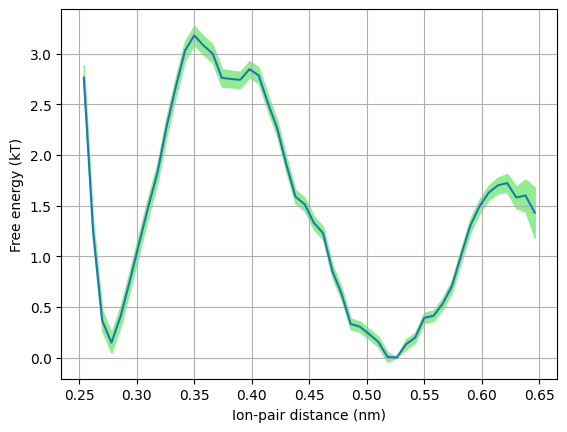

In [6]:
import pymbar
import numpy as np
import matplotlib.pyplot as plt
from pymbar import timeseries

# Step 1: Setting up
K = 8                                       # number of umbrellas
N_max = 5001                                # number of data points in each timeseries of ion-pair distance
kT = 1.381e-23 * 6.022e23 / 1000 * 300      # 1 kT converted to kJ/mol at 300 K
beta_k = np.ones(K) / kT                    # inverse temperature of simulations (in 1/(kJ/mol)) 
d_min, d_max = 0.25, 0.65                   # minimum and maximum of the CV for plotting the FES
nbins = 50                                  # number of bins for FES
N_k, g_k = np.zeros(K, int), np.zeros(K)    # number of samples and statistical inefficiency of different simulations
d_kn = np.zeros([K, N_max])                 # d_kn[k,n] is the ion-pair distance (in nm) for snapshot n from umbrella simulation k
u_kn = np.zeros([K, N_max])                 # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
uncorrelated_samples = []                   # Uncorrelated samples of different simulations
K_k = np.ones(K) * 8000                   
# K_k = np.array([0, 0.3, 0.65, 1, 1, 1, 1, 1]) * 8000
# restraint_lambdas = np.array([0.00, 0.30, 0.65, 1.00, 1.00, 1.00, 1.00, 1.00])
# k1 = 4000
# k2 = 8000
# K_k = np.array([(1 - i) * k1 + i * k2 for i in restraint_lambdas])

# Step 2: Read in and subsample the timeseries
for k in range(K):
    d_kn[k] = np.transpose(np.loadtxt(f'rep_{k}/NaCl_REUS_pullx.xvg', comments=['@', '#']))[1]
    N_k[k] = len(d_kn[k])
    d_temp = d_kn[k, 0:N_k[k]]
    g_k[k] = timeseries.statistical_inefficiency(d_temp)     
    print(f"Statistical inefficiency of simulation {k}: {g_k[k]:.3f}")
    indices = timeseries.subsample_correlated_data(d_temp, g=g_k[k]) # indices of the uncorrelated samples
    
    # Update u_kn and d_kn with uncorrelated samples
    N_k[k] = len(indices)    # At this point, N_k contains the number of uncorrelated samples for each state k                
    u_kn[k, 0:N_k[k]] = u_kn[k, indices]
    d_kn[k, 0:N_k[k]] = d_kn[k, indices]
    uncorrelated_samples.append(d_kn[k, indices])

d0_k = np.array([d_kn[i][0] for i in range(K)])    
N_max = np.max(N_k) # shorten the array size
u_kln = np.zeros([K, K, N_max]) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kn -= u_kn.min()  # shift the minimum of the FES to 0

# Step 3: Bin the data
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(d_min, d_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])

# Step 4: Evaluate reduced energies in all umbrellas
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image ion-pair distance deviation from umbrella center l
        dd = d_kn[k,n] - d0_k  # delta d

        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (K_k / 2) * dd ** 2

# Step 5: Compute, output, and plot the FES
fes = pymbar.FES(u_kln, N_k, verbose=False)
histo_params = {'bin_edges': bin_edges}
d_n = pymbar.utils.kn_to_n(d_kn, N_k=N_k)
fes.generate_fes(u_kn, d_n, fes_type='histogram', histogram_parameters=histo_params)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
f_i = results["f_i"]
df_i = results["df_i"]

with open('fes.dat', 'w') as f:
    f.write("# free energy profile (in units of kT), from histogramming\n")
    f.write(f"# {'bin':>8s} {'f':>8s} {'df':>8s} \n")
    for i in range(nbins):
       f.write(f"{bin_center_i[i]:>8.3f} {f_i[i]:>8.3f} {df_i[i]:>8.3f} \n")

plt.figure()
plt.plot(bin_center_i, f_i)
plt.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.grid()

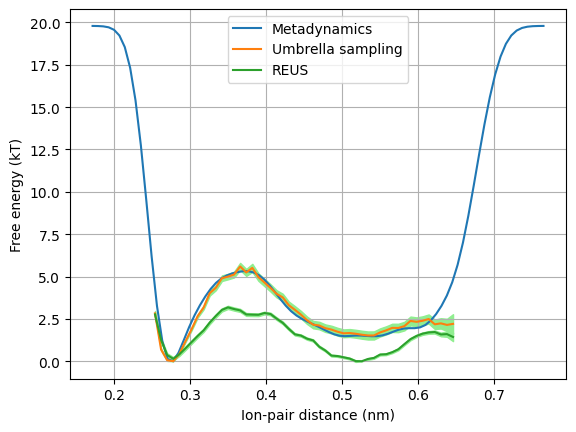

In [9]:
fes_MetaD = np.transpose(np.loadtxt('../Exercise_3/mpi_based/fes.dat', comments=['@', '#']))
fes_US = np.transpose(np.loadtxt('../Exercise_2/fes.dat', comments=['@', '#']))
fes_REUS = np.transpose(np.loadtxt('fes.dat', comments=['@', '#']))

fes_US[1] = fes_US[1] - min(fes_US[1])
fes_REUS[1] = fes_REUS[1] - min(fes_REUS[1])

kT = 300 * 1.380649E-23 * 6.02214076E23 / 1000   # 1 kT in kJ/mol
plt.plot(fes_MetaD[0], fes_MetaD[1] / kT, label='Metadynamics')
plt.plot(fes_US[0], fes_US[1], label='Umbrella sampling')
plt.plot(fes_REUS[0], fes_REUS[1], label='REUS')

plt.fill_between(fes_US[0], fes_US[1] - fes_US[2], fes_US[1] + fes_US[2], color='lightgreen')
plt.fill_between(fes_REUS[0], fes_REUS[1] - fes_REUS[2], fes_REUS[1] + fes_REUS[2], color='lightgreen')

plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.legend()
plt.grid()

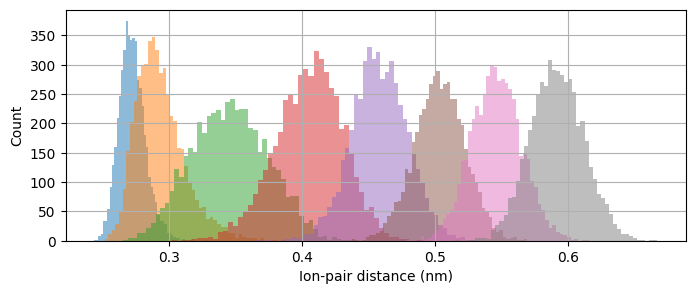

In [10]:
pullx_data = [np.transpose(np.loadtxt(f'rep_{i}/NaCl_REUS_pullx.xvg', comments=['@', '#'])) for i in range(8)]
dist_list = [data[1] for data in pullx_data]

plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(dist_list[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()